In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import glob
from tqdm import tqdm
import sys
import os

import barbershop
from inv_bol import Astero_Clump

from astropy.table import Table
from scipy import integrate
from pystellibs import Kurucz
from synphot import SpectralElement

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Define solar parameters
Rsol = 695700e3 #meters
Tsol = 5778 #K
Msol = 1.989e30 #Kg
Numaxsol = 3090 #Huber et al 2011ish
Dnusol = 135.1
stefboltz = 5.670367e-8 #Wm-2K-4
Lsol = 4 * np.pi * stefboltz * Rsol**2 * Tsol**4
gsol = 27400. #cms^2
Zsol = 0.01756
Asol = 4 * np.pi * (Rsol*100)**2

Mbolsol = 4.74  #Torres 2010?
Mksol = 3.28 #Bohlin & Gilliland 2004
Mksol_err = 0.09

In [3]:
def get_yu():
    #Read in Jie Yu
    print('Reading in Yu+2018')
    sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table1.txt'
    yu18_1 = pd.read_csv(sfile, sep='|')
    sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table2.txt'
    yu18_2 = pd.read_csv(sfile, sep='|')
    yu18 = pd.merge(yu18_1, yu18_2, on='KICID',how='outer')
    yu18.rename(columns={'KICID':'KIC','EvoPhase':'stage'},inplace=True) #For consistency
    yu18.stage[yu18.stage == 0] = 'U'
    yu18.stage[yu18.stage == 1] = 'RGB'
    yu18.stage[yu18.stage == 2] = 'HeB'

    #Lets build our new dataframe!
    df = pd.DataFrame()
    HeB = yu18.stage == 'HeB'
    df['KIC'] = yu18.KIC[HeB]
    df['numax'] = yu18.numax[HeB]
    df['numax_err'] = yu18['err_x'][HeB]
    df['dnu'] = yu18.dnu
    df['dnu_err'] = yu18['err.1_x'][HeB]
    df['Teff'] = yu18.Teff[HeB]
    df['Teff_err'] = yu18['err_y'][HeB]
    df['[Fe/H]'] = yu18['Fe/H'][HeB]
    df['[Fe/H]_err'] = yu18['err.2_y'][HeB]
    df['logg'] = yu18['logg'][HeB]
    df['logg_err'] = yu18['err.1_y'][HeB]
    df['M'] = yu18['M_noCorrection'][HeB]
    df['M_err'] = yu18['err.3_y'][HeB]
    df['R'] = yu18['R_noCorrection'][HeB]
    df['R_err'] = yu18['err.4_y'][HeB]
    df['Z'] = Zsol * 10**df['[Fe/H]']
    return df

df = get_yu()

Reading in Yu+2018


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [4]:
'''Lets build up the catalogue to Mbol for these stars
The asteroseismic values are already computed in Yu+18'''
AC = Astero_Clump(df, df.numax, df.dnu, df.Teff,\
                 _numax_err = df.numax_err, _dnu_err = df.dnu_err, _Teff_err = df.Teff_err)
df['L'] = AC.get_luminosity()/Lsol
df['L_err'] = AC.get_luminosity_err()/Lsol
df['Mbol'] = AC.get_bolmag()
df['Mbol_err'] = AC.get_bolmag_err()

In [7]:
'''Generate a spectrum for every star in our sample'''
spect = Kurucz() #Call in the spectrum
tracks = 'Kurucz'

logteff = np.log10(df.Teff.values)
logg = df.logg.values
logL = np.log10(df.L.values)
Z = df.Z.values
Mbol = df.Mbol.values
ap = (logteff, logg, logL, Z)
ap = Table(ap, names=('logT','logg','logL','Z'))

_, spectra = spect.generate_individual_spectra(ap)


In [8]:
'''Turning the annoying spectra array into a numpy array'''
print(spectra[0])
spectra = np.array(spectra)
print(spectra[0])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.42047095e+23
 1.84100446e+23 1.07599442e+23] erg / angstrom * second
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.42047095e+23
 1.84100446e+23 1.07599442e+23]


In [9]:
'''Lets get the J H and K filters'''
J = SpectralElement.from_filter('bessel_j')
H = SpectralElement.from_filter('bessel_h')
K = SpectralElement.from_filter('bessel_k')

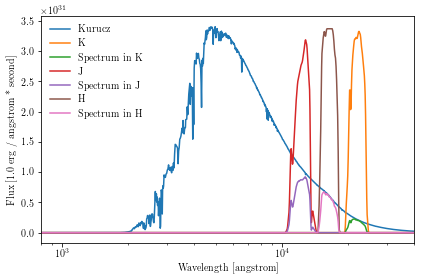

In [10]:
'''Lets plot a single spectra with the relevant passbands for illustration'''
sb = spectra[0]
plt.figure()
plt.semilogx(spect._wavelength, sb, label=tracks)
plt.semilogx(spect._wavelength, K(spect._wavelength)*sb.max(), label='K')
plt.semilogx(spect._wavelength, sb*K(spect._wavelength), label='Spectrum in K')
plt.semilogx(spect._wavelength, J(spect._wavelength)*sb.max(), label='J')
plt.semilogx(spect._wavelength, sb*J(spect._wavelength), label='Spectrum in J')
plt.semilogx(spect._wavelength, H(spect._wavelength)*sb.max(), label='H')
plt.semilogx(spect._wavelength, sb*H(spect._wavelength), label='Spectrum in H')
plt.legend(frameon=False, loc='upper left')
plt.xlabel('Wavelength [{0}]'.format(spect.wavelength_unit))
plt.xlim(800, 4e4)
plt.ylabel('Flux [{0}]'.format(spect.flux_units))
plt.tight_layout()
plt.show()

In [11]:
'''Now lets integrate all the spectra!'''
fl = np.zeros(len(df))
Kslfl = np.zeros(len(df))
Jslfl = np.zeros(len(df))
Hslfl = np.zeros(len(df))

for idx in tqdm(range(len(df))):
    fl[idx] = integrate.simps(spectra[idx], x=spect._wavelength)
    Kslfl[idx] = integrate.simps(spectra[idx] * K(spect._wavelength), x=spect._wavelength)
    Jslfl[idx] = integrate.simps(spectra[idx] * J(spect._wavelength), x=spect._wavelength)
    Hslfl[idx] = integrate.simps(spectra[idx] * H(spect._wavelength), x=spect._wavelength)

100%|██████████| 7703/7703 [00:11<00:00, 689.19it/s]


In [12]:
'''NEED TO PROPAGATE ERRORS THROUGH ON BC FIRST'''
BCk = 2.5*np.log10(Kslfl/fl) + 5.6646
BCj = 2.5*np.log10(Jslfl/fl) + 4.1493
BCh = 2.5*np.log10(Hslfl/fl) + 4.7712

In [16]:
'''Calculate absolute magnitudes'''
Mk_ast = df.Mbol.values - BCk
Mj_ast = df.Mbol.values - BCj
Mh_ast = df.Mbol.values - BCh
print('Mk: '+str(Mk_ast[0]) + r' $\pm$ ' + str(df.Mbol_err.values[0]))
print('Mj: '+str(Mj_ast[0]) + r' $\pm$ ' + str(df.Mbol_err.values[0]))
print('Mh: '+str(Mh_ast[0]) + r' $\pm$ ' + str(df.Mbol_err.values[0]))

Mk: -1.7042809684582982 $\pm$ 0.20579723532902242
Mj: -1.2202418770825498 $\pm$ 0.20579723532902242
Mh: -1.6465881489914986 $\pm$ 0.20579723532902242


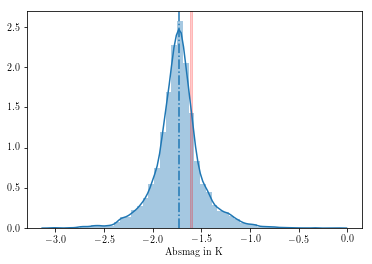

In [17]:
'''Make some distplots to compare to Hawkins'''
hawkvals = dict({'Ks':-1.61,'J':-0.93,'H':-1.46})
hawkerr = 0.01

sns.distplot(Mk_ast)
plt.axvspan(hawkvals['Ks']-hawkerr,hawkvals['Ks']+hawkerr,alpha=.2,color='r')
plt.xlabel('Absmag in K')
plt.axvline(np.median(Mk_ast),linestyle='-.')
plt.show()

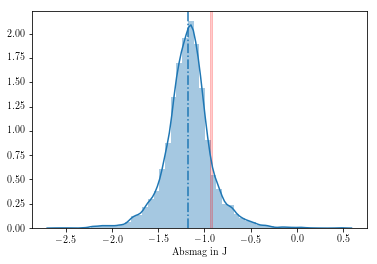

In [18]:
sns.distplot(Mj_ast)
plt.axvspan(hawkvals['J']-hawkerr,hawkvals['J']+hawkerr,alpha=.2,color='r')
plt.xlabel('Absmag in J')
plt.axvline(np.median(Mj_ast),linestyle='-.')
plt.show()

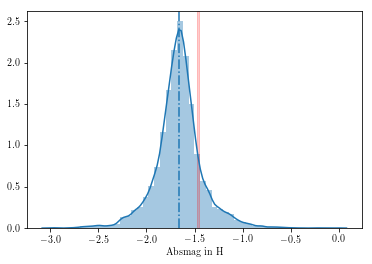

In [19]:
sns.distplot(Mh_ast)
plt.axvspan(hawkvals['H']-hawkerr,hawkvals['H']+hawkerr,alpha=.2,color='r')
plt.xlabel('Absmag in H')
plt.axvline(np.median(Mh_ast),linestyle='-.')
plt.show()